<a href="https://colab.research.google.com/github/mintseok/MachineLearning/blob/main/Deep%20Learnig%20from%20Scratch%202/4%EB%8B%A8%EC%9B%90%20CBOW%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 구글 드라이브 mount하기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
cd /content/drive/MyDrive/밑시딥2/deep-learning-from-scratch-2

/content/drive/MyDrive/밑시딥2/deep-learning-from-scratch-2


# CBOW를 위한 function들 만들어주기!

In [17]:
# 저번주의 내용 불러와주기
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus) # [0 1 2 3 4 1 5 6]
print(id_to_word) # {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


맥락을 찾아주는 함수

In [24]:
import numpy as np
# 맥락을 정리해주는 함수
def create_contexts_target(corpus, window_size=1):
  target = corpus[window_size:-window_size]
  contexts = []

  for idx in range(window_size, len(corpus)-window_size):
    cs = []
    for t in range(-window_size, window_size + 1):      
      if t == 0:               # 자기 자신에 대해서는 문맥에 추가 X
        continue      
      cs.append(corpus[idx + t]) # 문맥 추가
    contexts.append(cs) # 각각의 index에 대해 cs를 contexts에 추가

  return np.array(contexts), np.array(target)

In [27]:
contexts, target = create_contexts_target(corpus, window_size=1)
print("contexts: \n", contexts)
print("target: \n", target)

contexts: 
 [[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
target: 
 [1 2 3 4 1 5]


맥락을 one-hot encoding 해주기

In [28]:
from common.util import convert_one_hot

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# CBOW 모델 구현

CBOW는 맥락으로부터 타깃을 추측하는 신경망

In [39]:
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size
    
    # 가중치 초기화
    W_in = 0.01 * np.random.randn(V, H).astype('f') # W_in 과 W_out 은 서로 전치행렬 느낌
    W_out = 0.01 * np.random.randn(H, V).astype('f')

    # 계층 생성
    self.in_layer0 = MatMul(W_in) # W_in을 공유한다
    self.in_layer1 = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    self.loss_layer = SoftmaxWithLoss()

    # 모든 가중치와 기울기를 리스트에 모은다.
    layers = [self.in_layer0, self.in_layer1, self.out_layer]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    # 인스턴스 변수에 단어의 분산 표현을 저장한다
    self.word_vecs = W_in

  def forward(self, contexts, target):
    h0 = self.in_layer0.forward(contexts[:, 0])
    h1 = self.in_layer1.forward(contexts[:, 1])
    h = (h0 + h1) * 0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss

  def backward(self, dout=1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da += 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None

모델 학습시키기

In [ ]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [45]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

you [-1.3954886 -1.3973428 -1.4008445 -1.4225951 -1.3911105]
say [-1.8091927 -1.8273323 -1.824345  -1.8096116 -1.7952161]
goodbye [-1.6860394 -1.6714349 -1.6679027 -1.6858457 -1.6828219]
and [-1.6822274 -1.6810949 -1.6647189 -1.6458606 -1.6770265]
i [-1.6753969 -1.6712452 -1.6691475 -1.6957257 -1.6917335]
hello [-1.3863217 -1.3878337 -1.4047762 -1.3960998 -1.4144019]
. [-1.3664551 -1.4405501 -1.423384  -1.4054412 -1.3659613]


# 나만의 문장으로 시행시켜보기

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 26 |

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

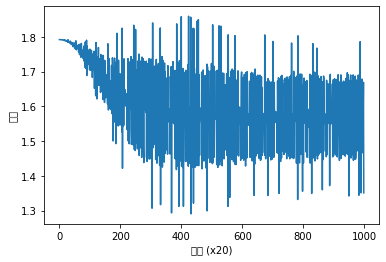

In [46]:
text = '안녕, 나는 허민석이야. 나는 운동을 좋아해.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [47]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

안녕, [-1.3991275 -1.4047481 -1.4149818 -1.4096932 -1.4023286]
나는 [-1.8119606 -1.8274201 -1.8458737 -1.8246186 -1.8208084]
허민석이야 [-1.6931837 -1.6697454 -1.690014  -1.6556603 -1.6576593]
. [-1.8141102 -1.8240157 -1.8271743 -1.8110157 -1.8428003]
운동을 [-1.699152  -1.6882268 -1.6749306 -1.6885723 -1.6860664]
좋아해 [-1.4033188 -1.3989791 -1.3955711 -1.4265606 -1.4183223]
